## **Learning Invariant Representations for Classification** - Yale Face Dataset

File:  yale_apca_redict.ipynb

Author:  Billy Carson

Date written:  05-09-2021

Last modified:  05-15-2021

> Description: This script uses adversarial APCA to learn representations invariant to lighting conditions. Azimuth (location of the lighting source) is treated as the concomitant/nuisance data, while the image is considered the primary data. Adverarial APCA learns an invariant representation for various adversarial strength values. Subsequently, logistic regression uses the learned invariant representation to make predictions on individual identity.


### **Import modules**

In [9]:
# Import modules
import os
import numpy as np
import time
import PIL
from PIL import Image
from scipy.interpolate import make_interp_spline, BSpline
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, mean_squared_error, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from apca.models import *
from apca.metrics import *

# Import data loading functions
from load_data import *
from preprocessing import *

# Define random state
random_state = 0

# Plot switch
# Paper figure: True, documentation example figure: False
paper_fig = True


### **Load data**

In [2]:
# Load data into arrays
dir_path = '/hdd/carlson_lab/data/yale_face/cropped_b/'
resize_factor = 0.25
X, Y, labels_id, labels_shadow = load_cropped_yale_face(dir_path=dir_path, resize_factor=resize_factor)

# Image width and height
img_width_orig = 168
img_height_orig = 192
img_width = int(resize_factor * img_width_orig)
img_height = int(resize_factor * img_height_orig)

# Display data dimensions
print('\nData dimensions:\n')
print('  X shape:  (%d, %d)' % (X.shape))
print('  Y shape:  (%d, %d)' % (Y.shape))
print('  labels shape:  (%d,)\n' % (labels_id.shape))



Data dimensions:

  X shape:  (411, 2016)
  Y shape:  (411, 1)
  labels shape:  (411,)



### **Split data**

In [3]:
# Split data
X_train, X_test, Y_train, Y_test, labels_id_train, labels_id_test, labels_shadow_train, \
labels_shadow_test = train_test_split(X, Y, labels_id, labels_shadow, test_size=0.5,
                                      shuffle=True, random_state=random_state)

# Display split details
print('\nTest/train split details:\n')
print('  Training samples:  %d' % (X_train.shape[0]))
print('  Test samples:  %d\n' % (X_test.shape[0]))



Test/train split details:

  Training samples:  205
  Test samples:  206



### **Scale data**

In [4]:
# Instantiate scaler objects
feature_range = (0, 1)
scaler_X = RangeScaler(feature_range=feature_range, copy=True)
scaler_Y = RangeScaler(feature_range=feature_range, copy=True)

# Scale primary data to between 0 and 1
X_train_scaled = scaler_X.fit_transform(X=X_train)
X_test_scaled = scaler_X.transform(X=X_test)

# Scale concomitant data to between 0 and 1
Y_train_scaled = scaler_Y.fit_transform(X=Y_train)
Y_test_scaled = scaler_Y.transform(X=Y_test)


### **Classify identity** - Adversarial APCA

In [5]:
# Number of components
n_components = 100

# Adversary strength list
mu_lo = 0.0
mu_hi = 16000.0
mu_step = 500.0
mu_list = list(np.arange(mu_lo, mu_hi + mu_step, mu_step))

# Initialize and instantiate
scaler_S = StandardScaler()
model = LogisticRegression(penalty='none', solver='lbfgs', max_iter=100000, random_state=random_state)
id_train_acc_list = []
id_test_acc_list = []
shadow_train_acc_list = []
shadow_test_acc_list = []

# Data prediction
model.fit(X_train_scaled, labels_id_train)
y_pred = model.predict(X_test_scaled)
test_acc = accuracy_score(y_true=labels_id_test, y_pred=y_pred)
print('\nLogistic regression on orginal image data:  %.3f\n' % (test_acc))

# Iterate over increasing adversary strengths
for mu in tqdm(mu_list):
    # Instantiate APCA model with new adversary strength value
    aapca = aAPCA(n_components=n_components, mu=mu, inference='joint')
    
    # Decompose with APCA
    S_train = aapca.fit_transform(X=X_train_scaled, Y=Y_train_scaled)
    S_test = aapca.transform(X=X_test_scaled, Y=Y_test_scaled)
    S_train_scaled = scaler_S.fit_transform(S_train)
    S_test_scaled = scaler_S.transform(S_test)
    
    # Predict ID
    model.fit(S_train_scaled, labels_id_train)
    y_pred_train = model.predict(S_train_scaled)
    train_acc = accuracy_score(y_true=labels_id_train, y_pred=y_pred_train)
    id_train_acc_list.append(train_acc)
    y_pred_test = model.predict(S_test_scaled)
    test_acc = accuracy_score(y_true=labels_id_test, y_pred=y_pred_test)
    id_test_acc_list.append(test_acc)
    
    # Predict shadow location
    no_shadow_idx_train = np.where(labels_shadow_train!=0.5)[0].ravel()
    no_shadow_idx_test = np.where(labels_shadow_test!=0.5)[0].ravel()
    model.fit(S_train_scaled[no_shadow_idx_train, :], labels_shadow_train[no_shadow_idx_train])
    y_pred_train = model.predict(S_train_scaled[no_shadow_idx_train, :])
    train_acc = accuracy_score(y_true=labels_shadow_train[no_shadow_idx_train], y_pred=y_pred_train)
    shadow_train_acc_list.append(train_acc)
    y_pred_test = model.predict(S_test_scaled[no_shadow_idx_test, :])
    test_acc = accuracy_score(y_true=labels_shadow_test[no_shadow_idx_test], y_pred=y_pred_test)
    shadow_test_acc_list.append(test_acc)

# Display baseline PCA accuracy and max APCA accuracy
print('\nLogistic regression classification performance:\n')
print('  ID classification:')
print('    PCA components:  %.3f' % (id_test_acc_list[0]))
print('    APCA components (max acc.):  %.3f\n' % (np.max(id_test_acc_list)))
print('  Shadow location (left/right) classification:')
print('    PCA components:  %.3f' % (shadow_test_acc_list[0]))
print('    APCA components (min acc.):  %.3f\n' % (np.min(shadow_test_acc_list)))



Logistic regression on orginal image data:  0.636



  0%|          | 0/33 [00:00<?, ?it/s]


Logistic regression classification performance:

  ID classification:
    PCA components:  0.704
    APCA components (max acc.):  0.825

  Shadow location (left/right) classification:
    PCA components:  0.979
    APCA components (min acc.):  0.656



### **Display results** - Performance as a function of adversary strength

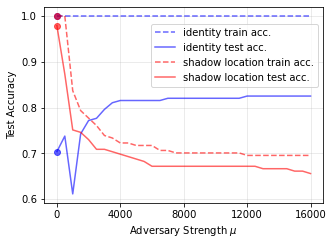

In [10]:
# Plot accuracy as a function of adversary strength
if paper_fig:
    fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5.0, 3.6))
else:
    fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8.0, 3.8))
ax1.plot(mu_list, id_train_acc_list, c='blue', linestyle='--', alpha=0.6, label='identity train acc.')
ax1.scatter(mu_list[0], id_train_acc_list[0], c='blue', alpha=0.6)
ax1.plot(mu_list, id_test_acc_list, c='blue', linestyle='-', alpha=0.6, label='identity test acc.')
ax1.scatter(mu_list[0], id_test_acc_list[0], c='blue', alpha=0.6)
ax1.plot(mu_list, shadow_train_acc_list, c='red', linestyle='--', alpha=0.6, label='shadow location train acc.')
ax1.scatter(mu_list[0], shadow_train_acc_list[0], c='red', alpha=0.6)
ax1.plot(mu_list, shadow_test_acc_list, c='red', linestyle='-', alpha=0.6, label='shadow location test acc.')
ax1.scatter(mu_list[0], shadow_test_acc_list[0], c='red', alpha=0.6)
ax1.set_xticks([0, 4000, 8000, 12000, 16000])
ax1.set_yticks([0.60, 0.70, 0.80, 0.90, 1.00])
# ax1.set_title('Yale Face Dataset - Classification Results')
ax1.set_xlabel('Adversary Strength $\mu$')
ax1.set_ylabel('Test Accuracy')
ax1.grid(alpha=0.3)
ax1.set_axisbelow(True)
ax1.legend(loc='upper right', bbox_to_anchor=(1.0, 0.94))
plt.show()

# Save figure
dpi = 600
if paper_fig:
    fig1.savefig('figures/yale_face_classification_paper.pdf', bbox_inches='tight', dpi=dpi)
else:
    fig1.savefig('figures/yale_face_classification_docs.pdf', bbox_inches='tight', dpi=dpi)
